In [2]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table, vstack
import hdbscan
from pathlib import Path
import seaborn as sns
import glob
import json
%matplotlib inline
sns.set_color_codes()

In [3]:
ROOT_PATH = Path("..") 

In [4]:
table = Table.read("Good-LD-Halpha-DR3_noFlag_merge.ecsv", format="ascii.ecsv")

In [5]:

len(table)

8817

In [7]:
table.colnames

['Field',
 'ID',
 'RA',
 'DEC',
 'FWHM',
 'ISOarea',
 'KRON_RADIUS',
 'nDet_magPStotal',
 'PhotoFlagDet',
 'U_PStotal',
 'F378_PStotal',
 'F395_PStotal',
 'F410_PStotal',
 'F430_PStotal',
 'G_PStotal',
 'F515_PStotal',
 'R_PStotal',
 'F660_PStotal',
 'I_PStotal',
 'F861_PStotal',
 'Z_PStotal',
 'e_U_PStotal',
 'e_F378_PStotal',
 'e_F395_PStotal',
 'e_F410_PStotal',
 'e_F430_PStotal',
 'e_G_PStotal',
 'e_F515_PStotal',
 'e_R_PStotal',
 'e_F660_PStotal',
 'e_I_PStotal',
 'e_F861_PStotal',
 'e_Z_PStotal',
 'r - i',
 'r - J0660',
 'e(r - i)',
 'e(r - J0660)',
 'P(GoodPho)',
 'P(BadPho)']

In [8]:
# Colors
m =  (table["e_G_PStotal"] <= 0.2) & (table["e_R_PStotal"] <= 0.2) & (table["e_Z_PStotal"] <= 0.2)
zg = table['Z_PStotal'][m] - table['G_PStotal'][m]
gr = table['G_PStotal'][m] - table['R_PStotal'][m]

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


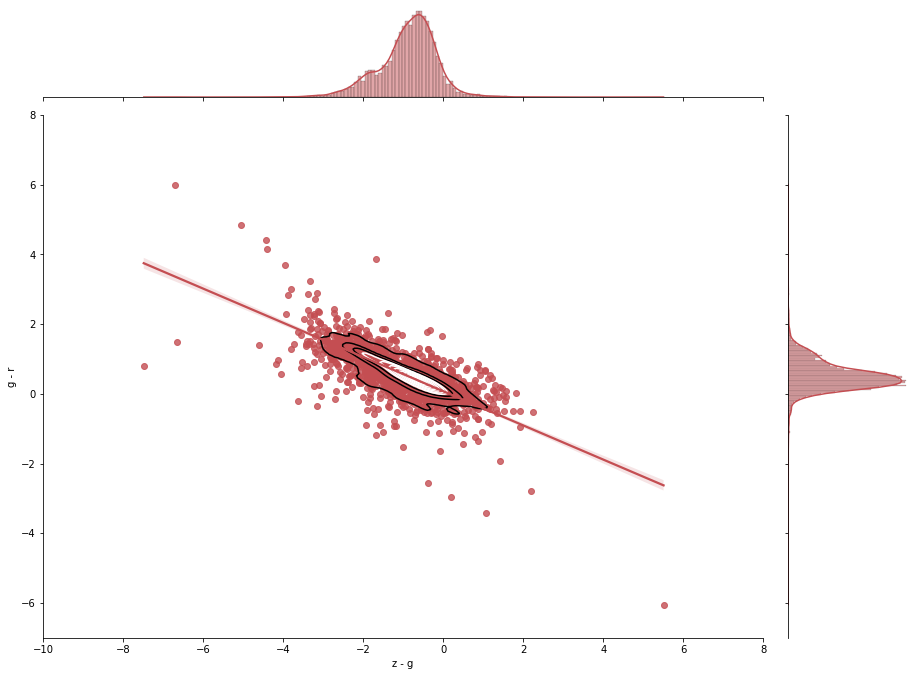

In [102]:
ax = sns.jointplot(zg, gr, kind="reg", color="r")
ax.ax_joint.set(xlim=[-10, 8], ylim=[-7, 8],
               xlabel=r"z - g",
    ylabel=r"g - r")
pal = sns.cubehelix_palette(start=1, rot=0, dark=-10, light=50, reverse=True, as_cmap=True)
sns.kdeplot(
    zg, gr,
    cmap=pal,
)
#ax.ax_joint.set_aspect("equal")
ax.fig.set_size_inches(14, 10)

# Using pomegranate

In [47]:
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution

In [78]:
X = np.array(list(zip(zg, gr)))
X.shape
# Standarized the data
X = StandardScaler().fit_transform(X)

In [79]:
rel_err = np.hypot(
    zg,
    gr,
)
weights = 1.0 / rel_err ** 2
weights[rel_err == 0.0] = np.nanmedian(weights)
max_weight = 4.0 * np.nanmedian(weights)
weights[weights > max_weight] = max_weight
weights[::10]


0.4805122138268466
0.9654679809723632
1.4492038911408265
2.2667998879453104
0.46438245952181734
1.0833433729475674
1.6615546883165109
1.315444150899702
0.29288172461306833
1.2779942505812178
3.333655842167278


In [80]:
N_COMPONENTS = 2

In [81]:
model = GeneralMixtureModel.from_samples(
    distributions=MultivariateGaussianDistribution,
    n_components=N_COMPONENTS,
    X=X,
    weights=weights,
)


In [82]:
plabels = model.predict(X)
plabels

array([1, 1, 1, ..., 0, 1, 1], dtype=int32)

In [83]:
xmin, xmax = 0.75, 15
ymin, ymax = 0.75, 15
NP = 1000
xx, yy = np.meshgrid(np.linspace(xmin, xmax, NP), np.linspace(ymin, ymax, NP),)
x_ = np.array(list(zip(xx.flatten(), yy.flatten())))
p_components = model.predict_proba(np.log10(x_)).reshape((NP, NP, N_COMPONENTS))
p_tot = model.probability(np.log10(x_)).reshape((NP, NP))
p_tot /= p_tot.max()

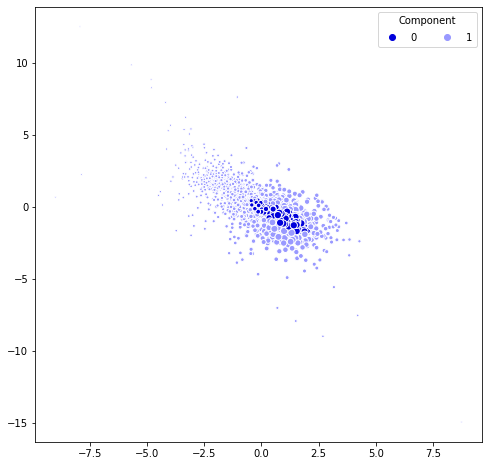

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
#   for k in range(1, N_COMPONENTS):
#    ax.contour(xx, yy, p_components[:, :, k], levels=[0.5], cmap="Reds_r", zorder=-2)
levels = np.array([0.001, 0.003, 0.01, 0.03, 0.1, 1.0])
GAMMA = 0.05
#ax.contourf(
    #xx, yy, p_tot ** GAMMA, levels=levels ** GAMMA, cmap="Greens", zorder=-1, alpha=0.5
#)
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=plabels,
    s=25 * np.sqrt(weights),
    edgecolors="w",
    linewidths=1,
    vmin=-1,
    vmax=4,
    cmap="seismic",
)
ax.set(
    #xscale="log",
    #yscale="log",
    #xlim=[xmin, xmax],
    #ylim=[ymin, ymax],
    #xlabel=r"Planitude, $\Pi$",
    #ylabel=r"Alatude, $\Lambda$",
)
ax.legend(*scatter.legend_elements(), ncol=2, title="Component")
#ax.set_aspect("equal")

# Fitting a Gaussian Mixture Model with Scikit-learn’s GaussianMixture() function 

In [85]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


In [86]:
# Standarized the data
#X = StandardScaler().fit_transform(X)

In [87]:
gmm = GaussianMixture(2, 
                     covariance_type='full', 
                     random_state=0).fit(X)

In [88]:
gmm.means_

array([[-0.39665326,  0.19692517],
       [ 0.08772225, -0.04355118]])

In [89]:
labels = gmm.predict(X)

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Z_PStotal', ylabel='G_PStotal'>

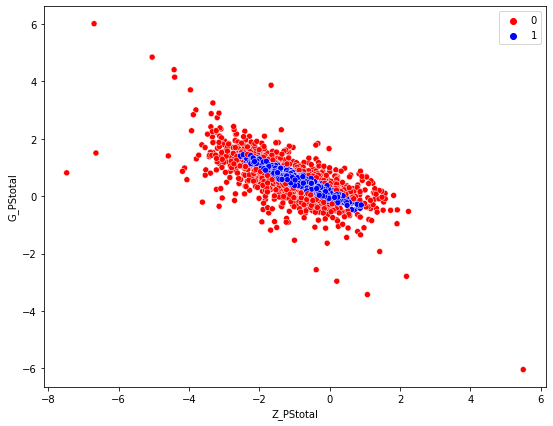

In [90]:
plt.figure(figsize=(9,7))
sns.scatterplot(zg, gr, 
                hue=labels,
                palette=["red","blue"])
#plt.savefig("fitting_Gaussian_Mixture_Models_with_3_components_scikit_learn_Python.png",
                    #format='png',dpi=150)

# Using k-nearst

In [115]:
from sklearn.cluster import KMeans

In [145]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

In [174]:
#predictions from kmeans
label = kmeans.labels_
pred = kmeans.predict(X)
print(label, pred)

[0 0 0 ... 1 1 1] [0 0 0 ... 1 1 1]


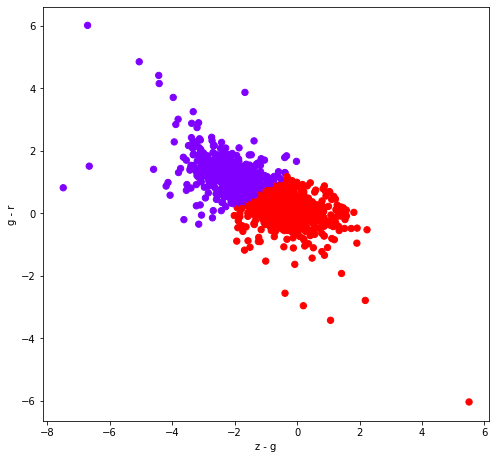

In [206]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(zg, gr, c=label, s=40, cmap="rainbow")
ax.set(
    #xscale="log",
    #yscale="log",
    #xlim=[0.75, 15],
    #ylim=[0.75, 15],
    xlabel=r"z - g",
    ylabel=r"g - r",
)
ax.set_aspect("equal")

# Using HDBSCAN

In [149]:
import hdbscan

In [169]:
# Applying HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=40, min_cluster_size=50, prediction_data=True).fit(X)
labels = clusterer.labels_

In [170]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_noise_ = list(labels).count(-1)

In [171]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of cluster points 0: 160
Estimated number of cluster points 1: 4167
Estimated number of cluster points 2: 0
Estimated number of noise points: 2969


/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Z_PStotal', ylabel='G_PStotal'>

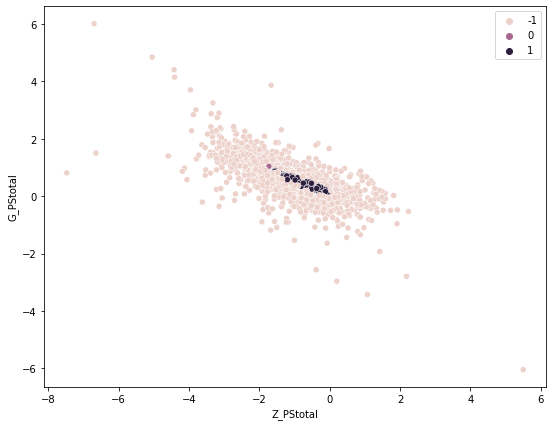

In [172]:
plt.figure(figsize=(9,7))
sns.scatterplot(zg, gr, 
                hue=labels,
                )

# Hierarchical Clustering

In [175]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
model.fit(X)

AgglomerativeClustering()

In [176]:
label_h=model.labels_

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Z_PStotal', ylabel='G_PStotal'>

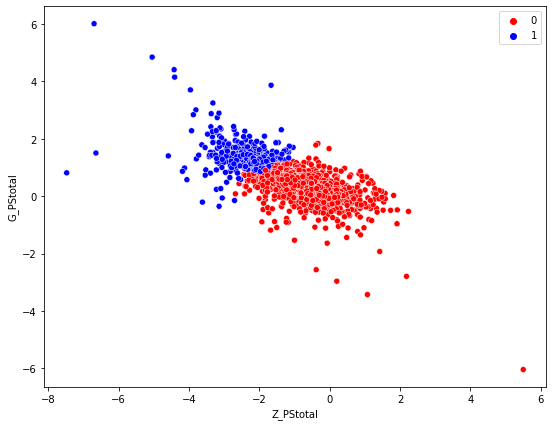

In [177]:
plt.figure(figsize=(9,7))
sns.scatterplot(zg, gr, 
                hue=label_h,
                palette=["red","blue"])

# OPTICS

In [186]:
from sklearn.cluster import OPTICS


In [202]:
clustering = OPTICS(min_samples=25).fit(X)
clustering.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [203]:
label_op = clustering.labels_

/home/luis/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Z_PStotal', ylabel='G_PStotal'>

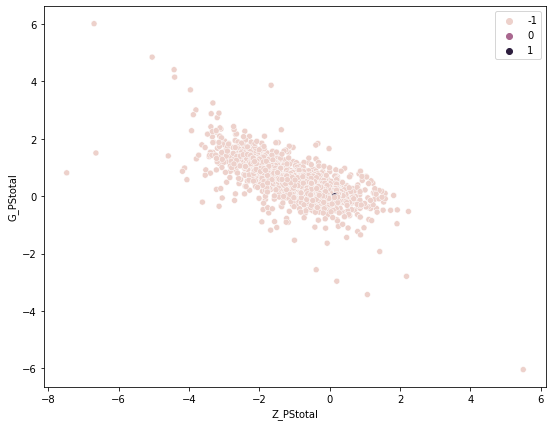

In [204]:
plt.figure(figsize=(9,7))
sns.scatterplot(zg, gr, 
                hue=label_op,
                )